In [19]:
! pip install mujoco

26625.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement mujoco (from versions: none)
ERROR: No matching distribution found for mujoco


In [1]:
import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T

from torch.distributions import Categorical
import numpy as np
import pandas as pd
import gym

from collections import deque
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

from collections import deque

In [2]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        output = F.softmax(x, dim=-1)
        return output

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        output = self.linear3(x)
        return output

In [23]:


class ActorCritic():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 5000
      self.max_steps = 500
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 120
      self.replay_buffer_capacity=5000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)

      self.state_count = env.observation_space.shape[0]
      self.action_count = env.action_space.n
      self.actor = Actor(self.state_count, self.action_count)
      self.critic = Critic(self.state_count, 1)#self.action_count) 
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0001)
      self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
      self.loss_func = F.mse_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./cartpole/actor.pth"
    
    def choose_action(self, state, test=False):
      if not test:
          action_prob = self.actor(state)
          actions_cat = Categorical(action_prob)

          current_action = actions_cat.sample()
          action_log_prob = actions_cat.log_prob(current_action)
          return current_action, action_log_prob, action_prob
      else:
          return self.get_q_value_for_state(state)#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.actor(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.actor.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_state = torch.from_numpy(obs).unsqueeze(0) 
        while not done:
          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          self.env.render()
          
          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 

          steps +=1
          
          current_state = next_state
          if steps==500 or reward_sum==470:
            done=True

        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)
    
    def loss(self):
      action_prob, current_actions, current_states, next_states, rewards, dones = self.get_minibatch_from_replay_buffer()   
      action_prob = action_prob.gather(1, current_actions.unsqueeze(1))
      target_rewards = deque()
      cd_reward = 0
      for idx in range(len(rewards)-1,-1,-1):
        if dones[idx]:
            cd_reward = rewards[idx]
        else:
            cd_reward = rewards[idx] + (self.gamma * cd_reward)
        target_rewards.appendleft(cd_reward)  

      target_rewards = torch.tensor(target_rewards,dtype=torch.float32).unsqueeze(1)
      for epoch in range(20):
        action_probs = self.actor(current_states)
        
        new_action_probs = action_probs.gather(1, current_actions.unsqueeze(1))
        # new_action_log = actions.log_prob(current_actions)
        pred_rewards = self.critic(current_states)

        policy_ratios = new_action_probs/action_prob 
        trpo = policy_ratios * (target_rewards - pred_rewards)
        clipped_trpo = torch.clamp(policy_ratios, 1-0.2, 1+0.2) * (target_rewards - pred_rewards)

        loss = (-torch.min(trpo, clipped_trpo) + self.loss_func(target_rewards, pred_rewards)).mean()
        
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
      
        loss.backward()
        # for param in self.actor.parameters():
        #     param.grad.data.clamp_(-1, 1)
        # for param in self.critic.parameters():
        #     param.grad.data.clamp_(-1, 1)
        
        self.actor_optimizer.step()
        self.critic_optimizer.step()

 


    def train(self, current_state, reward, next_state, done, action_log_prob, I):
      
      current_state_val = self.critic(current_state)
      next_state_val = self.critic(next_state) if not done else 0
  
      delta = reward + self.gamma*next_state_val - current_state_val
      actor_loss = (-1*action_log_prob*delta.item()*I)
      critic_loss = (delta**2)
      # print(actor_loss, critic_loss)
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      
      loss = actor_loss+critic_loss
      # (actor_loss + critic_loss).backward()
      # actor_loss.backward()
      loss.backward()
      for param in self.actor.parameters():
          param.grad.data.clamp_(-1, 1)
      for param in self.critic.parameters():
          param.grad.data.clamp_(-1, 1)
      
      self.actor_optimizer.step()
      self.critic_optimizer.step()

      return actor_loss.item(), critic_loss.item()
      
    def learn(self):
      
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        a_running_loss=0
        c_running_loss=0
        I = 1
        current_state = torch.from_numpy(obs).unsqueeze(0)
        while not done:
          with torch.no_grad():
            current_action, action_log_prob, action_prob = self.choose_action(current_state)

          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())

          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 


          self.replay_buffer.append((action_prob, current_action, current_state, next_state, curr_reward, done))

          # actor_loss, critic_loss = self.train(current_state, curr_reward, next_state, done, action_log_prob, I)
          I = self.gamma*I
          steps +=1
          current_state = next_state

          if steps==self.max_steps:
            done=True

        # self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 10 == 5 :
          self.loss()

        if episode % 100 == 99:
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100}')
          a_running_loss = 0.0
          c_running_loss = 0.0
          self.env.render()
          if sum(self.rewards_list[-200:])/200 >= 470:
            break
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.critic.load_state_dict(self.actor.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = self.replay_buffer
      action_log = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      curret_state_batch = torch.cat(tuple([exp[2] for exp in exp_batch]),dim=0)
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[5] for exp in exp_batch]))#.to(self.device)
      self.replay_buffer.clear()
      return action_log, current_action_batch, curret_state_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)



In [16]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
# env = gym.make("Ant-v4")
env.reset()
agent = ActorCritic(env)
agent.learn()

  2%|▏         | 101/5000 [00:11<11:06,  7.35episodes/s]

[Episode: 100] - Steps: 56.88 | Rewards: 56.88


  4%|▍         | 200/5000 [00:37<24:36,  3.25episodes/s]

[Episode: 200] - Steps: 178.9 | Rewards: 178.9


  6%|▌         | 300/5000 [01:20<28:28,  2.75episodes/s]  

[Episode: 300] - Steps: 335.29 | Rewards: 335.29


  8%|▊         | 400/5000 [02:22<49:42,  1.54episodes/s]  

[Episode: 400] - Steps: 426.02 | Rewards: 426.02


 10%|█         | 500/5000 [03:27<50:03,  1.50episodes/s]  

[Episode: 500] - Steps: 484.1 | Rewards: 484.1


 12%|█▏        | 599/5000 [04:34<33:35,  2.18episodes/s]  

[Episode: 600] - Steps: 484.23 | Rewards: 484.23


In [21]:
PATH = './cartpole/actor.pth'
torch.save(agent.actor.state_dict(), PATH)

In [22]:
PATH = './cartpole/critic.pth'
torch.save(agent.critic.state_dict(), PATH)

In [17]:
epsilon_list_train_dqn = agent.epsilon_list
reward_list_train_dqn = agent.rewards_list

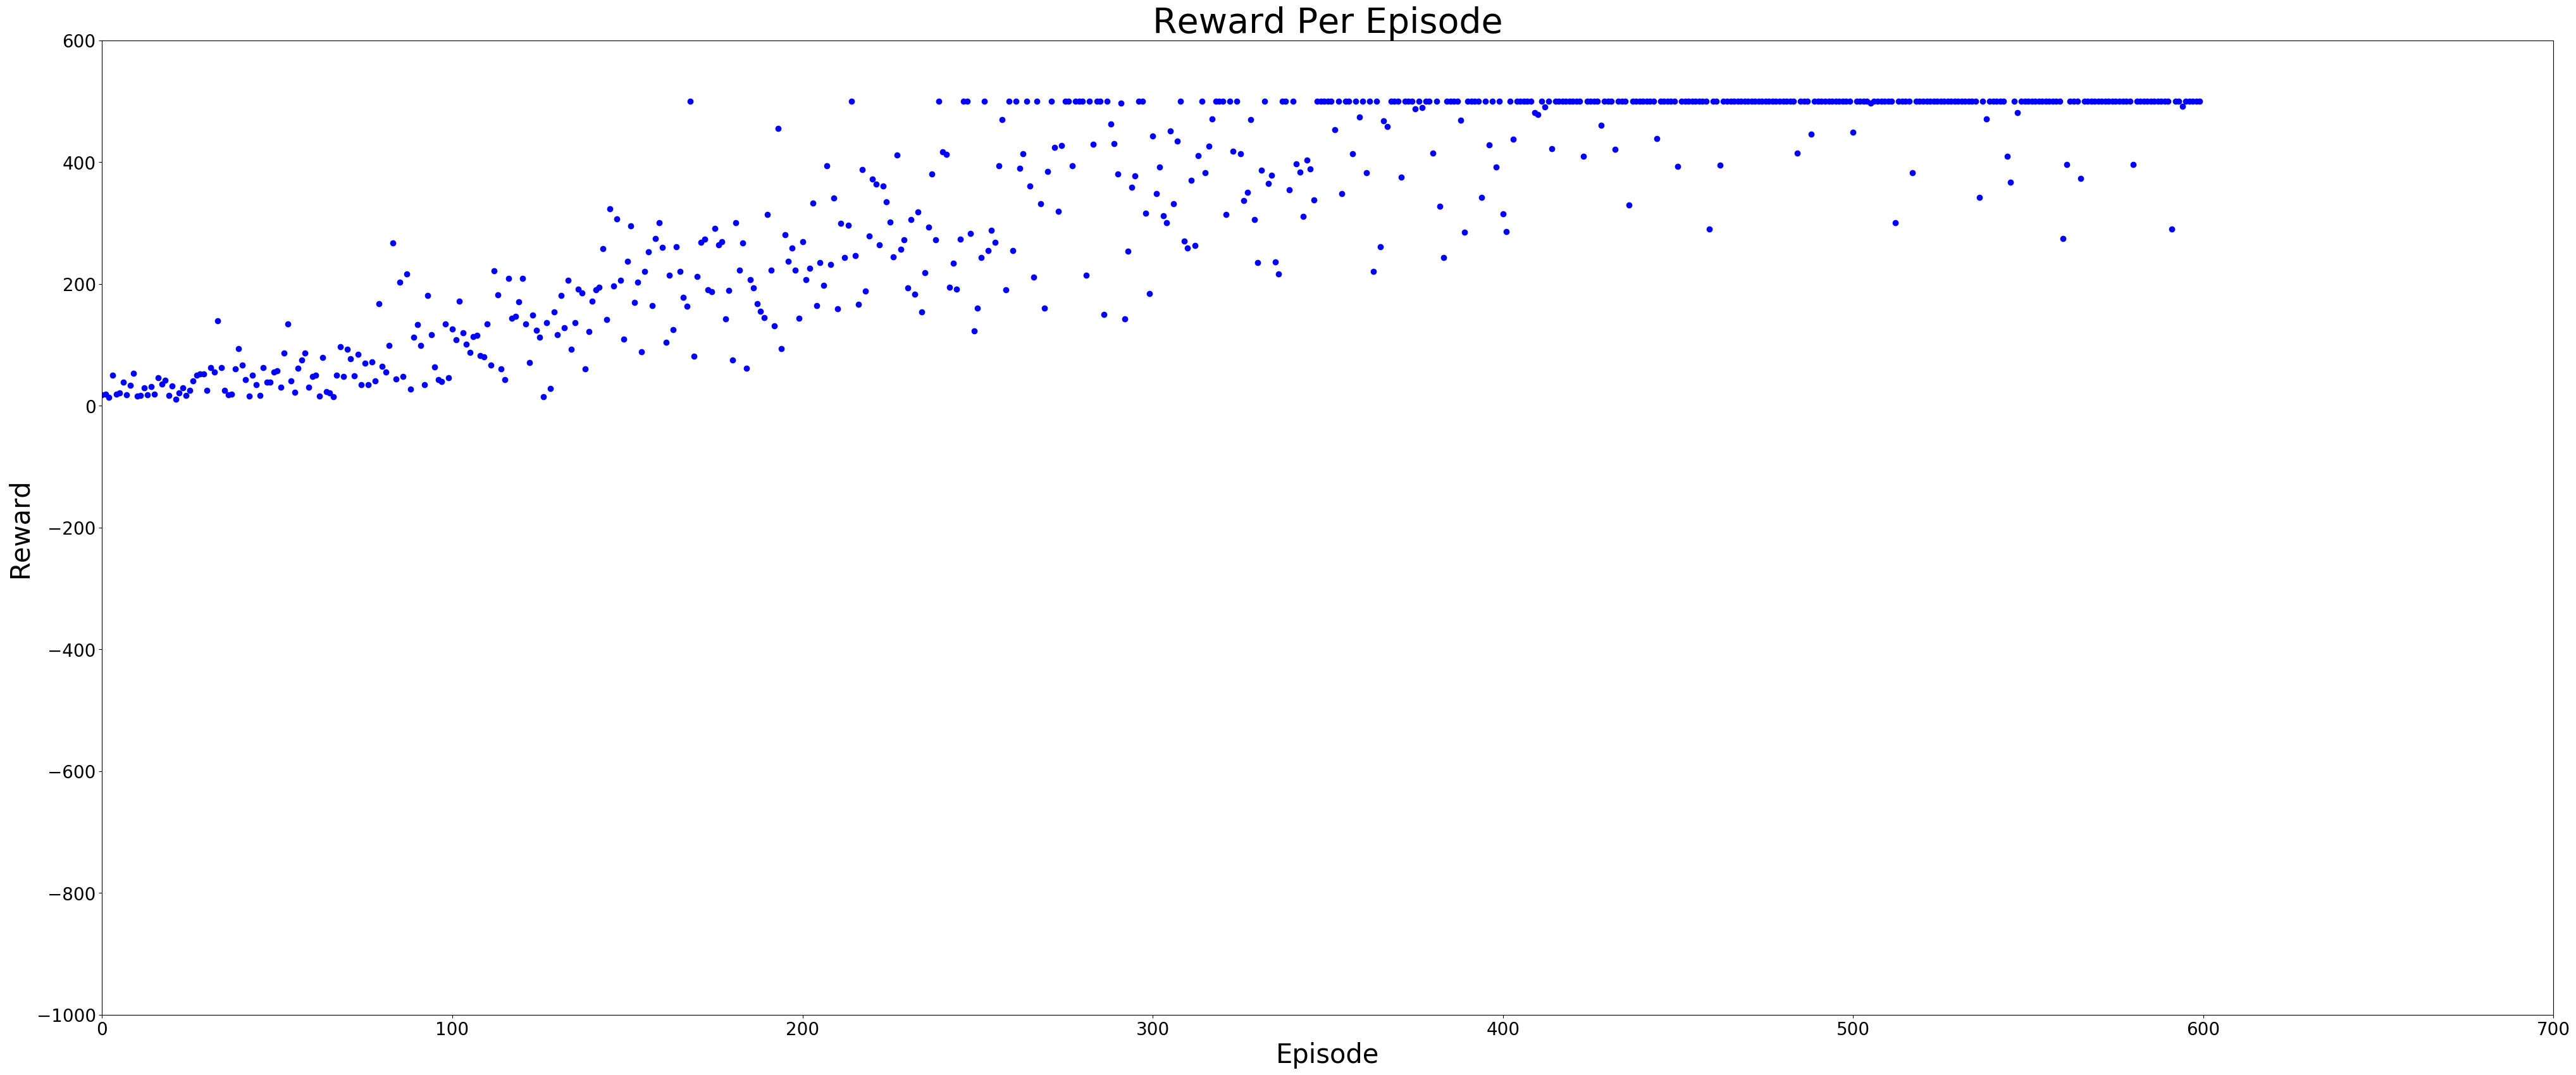

In [18]:
fig, (ax2) = plt.subplots(1,1)
fig.set_figheight(20)
fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_train_dqn, 'bo')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=700)
ax2.set_ylim(ymin=-1000, ymax=600)
plt.show()

In [19]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 6):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))


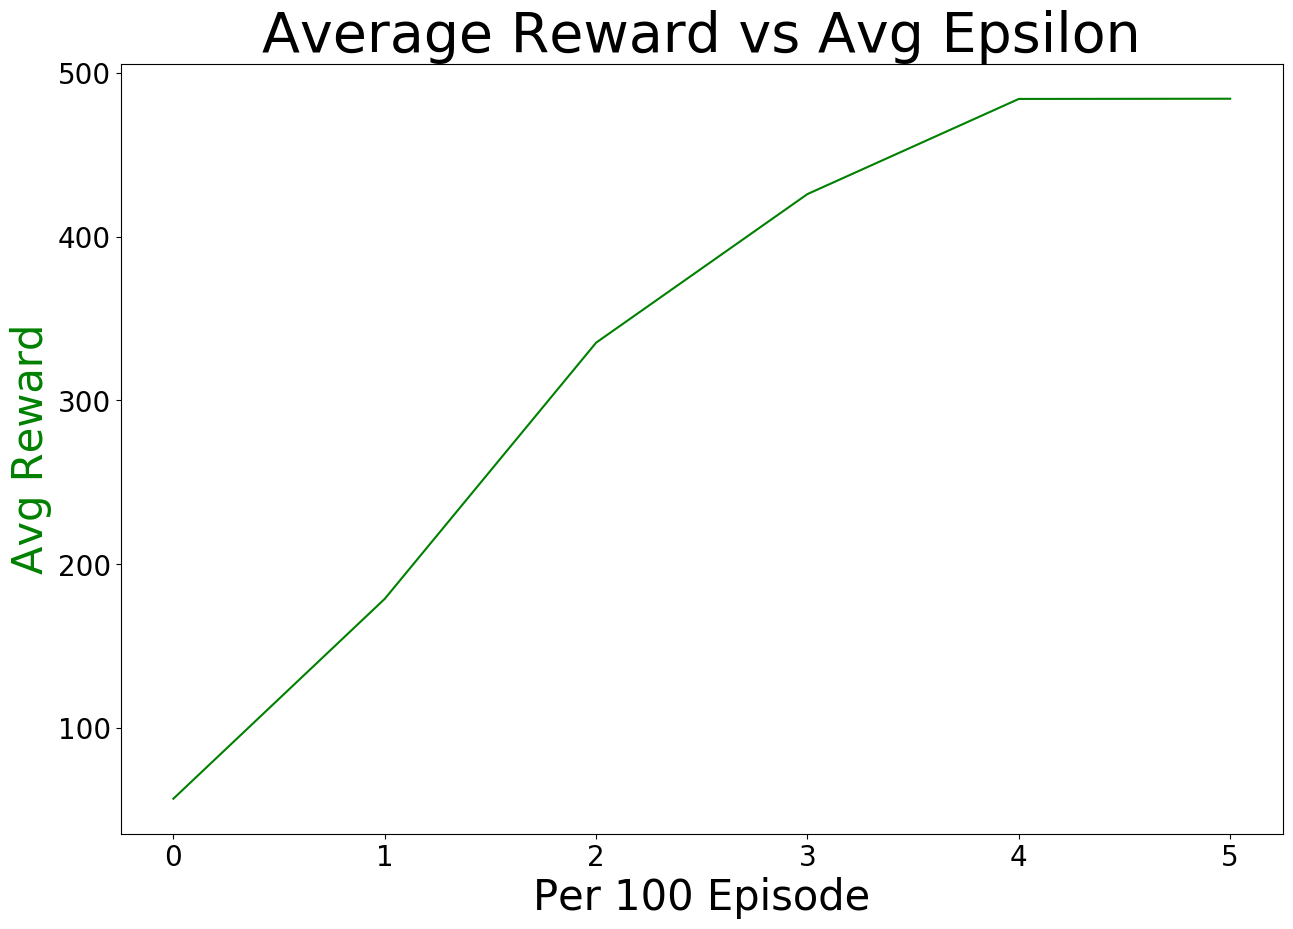

In [20]:
fig, ax2 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax2.set_title("Average Reward vs Avg Epsilon", size=40)
ax2.set_xlabel('Per 100 Episode', fontsize=30)
ax2.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [79]:
import json
with open('reward.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

# import json
# with open('backup/epsilon.json') as f:
#     epsilon_list_train_dqn = json.load(f)

In [28]:
env = gym.make('CartPole-v1', render_mode="human")
env.reset()
agent_test = ActorCritic(env)
agent_test.eval()

100%|██████████| 10/10 [03:20<00:00, 20.08s/episodes]


In [25]:
reward_list_test_dqn = agent_test.test_rewards_list

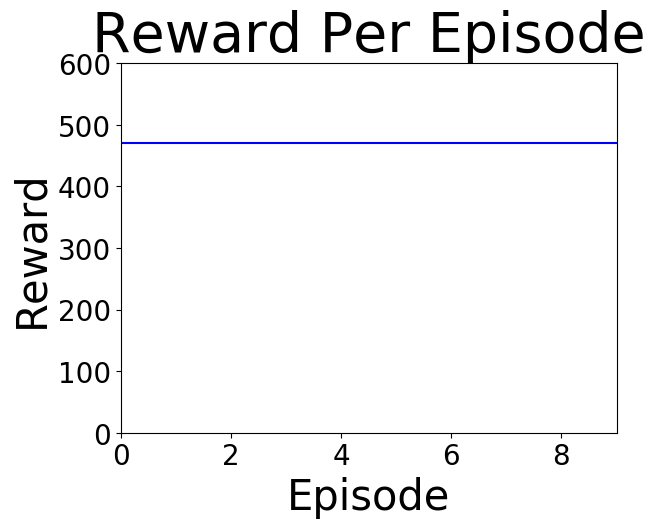

In [27]:
fig, (ax2) = plt.subplots(1,1)
# fig.set_figheight(50)
# fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_test_dqn, 'b-')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=9)
ax2.set_ylim(ymin=0, ymax=600)
plt.show()